In [ ]:
__author__ = "Zhenming Xu"
__email__ = "15216105346@163.com"
__date__ = "Aug 8, 2019"

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import sys
import seaborn as sns
from pandas import DataFrame
from pymatgen.ext.matproj import MPRester
from pymatgen.core.structure import Structure
from pymatgen.analysis.chemenv.coordination_environments.coordination_geometry_finder import LocalGeometryFinder
from pymatgen.analysis.chemenv.coordination_environments.chemenv_strategies import SimplestChemenvStrategy
from pymatgen.analysis.chemenv.coordination_environments.structure_environments import LightStructureEnvironments

In [ ]:
mp_api = MPRester()
structure = mp_api.get_structure_by_material_id('mp-841', final=True, conventional_unit_cell=True)
#[i for i,s in enumerate(structure.sites) if s.specie.name == 'Li']

In [ ]:
def anion_volume(A):
    V = A.volume
    anion_volume = round(V/len([i for i,s in enumerate(A.sites) if s.specie.name == 'O']),3)
    return anion_volume

In [ ]:
def analyse_chemenv_coordination(B):

    lgf = LocalGeometryFinder()
    lgf.setup_structure(structure=B)
    se = lgf.compute_structure_environments(only_atoms=['Li'], maximum_distance_factor=1.4)
    strategy = SimplestChemenvStrategy(distance_cutoff=1.4, angle_cutoff=0.3)
    lse = LightStructureEnvironments.from_structure_environments(strategy=strategy, structure_environments=se)
    a = []
    for j in [i for i,s in enumerate(B.sites) if s.specie.name == 'Li']:
        a = a + lse.coordination_environments[j]
        print(lse.coordination_environments[j])
        
    average_environment_information = {}
    average_environment_information['csm'] = round(DataFrame(a)['csm'].mean(), 3)
    average_environment_information['ce_fraction'] = round(DataFrame(a)['ce_fraction'].mean(), 4)
    
    if len(list(set(DataFrame(a)['ce_symbol'].tolist()))) > 2:
        average_environment_information['ce_symbol'] = 'others'
    elif len(list(set(DataFrame(a)['ce_symbol'].tolist()))) == 2 and (list(set(DataFrame(a)['ce_symbol'].tolist())) == ['T:4', 'O:6'] or list(set(DataFrame(a)['ce_symbol'].tolist())) == ['O:6', 'T:4']):
        average_environment_information['ce_symbol'] = 'O:6-T:4'
    elif len(list(set(DataFrame(a)['ce_symbol'].tolist()))) == 1 and 'T:4' in list(set(DataFrame(a)['ce_symbol'].tolist())):
        average_environment_information['ce_symbol'] = 'T:4'
    elif len(list(set(DataFrame(a)['ce_symbol'].tolist()))) == 1 and 'O:6' in list(set(DataFrame(a)['ce_symbol'].tolist())):
        average_environment_information['ce_symbol'] = 'O:6'
    else:
        average_environment_information['ce_symbol'] = 'others'
    return average_environment_information

In [ ]:
analyse_chemenv_coordination(structure)

In [ ]:
input_file = sys.argv[0]
data = pd.read_csv('stable_lithium_oxides_from_MP_database.csv')
total_stable_mp_ids = np.array(data.material_id).tolist()

In [ ]:
mp_api = MPRester()
c = []
k = 0
for material_id in total_stable_mp_ids:
    crystal_structure = mp_api.get_structure_by_material_id('{}'.format(material_id), final=True, conventional_unit_cell=True)
    b = analyse_chemenv_coordination(crystal_structure)
    b['mp-id'] = material_id
    b['anion_volume'] = anion_volume(crystal_structure)
    c.append(b)
    k += 1
    print(k, b)
DataFrame(c).to_csv('lithium_chemenv_coordination_environments_for_oxides.csv')
DataFrame(c)

{'O:6': 0.344, 'O:6-T:4': 0.021, 'T:4': 0.219, 'others': 0.415}


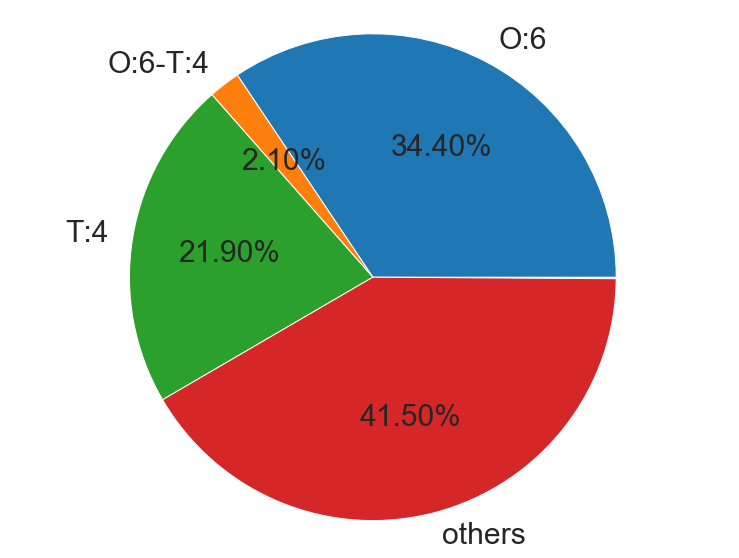

In [15]:
input_file = sys.argv[0]
data = pd.read_csv('lithium_chemenv_coordination_environments_for_oxides.csv')
coordination_environments = np.array(data.ce_symbol).tolist()
coordination_environments.sort()
anion_volumes = np.array(data.anion_volume).tolist()

a = {}
for i in Counter(coordination_environments).keys():
    a['{}'.format(i)] = round((Counter(coordination_environments))['{}'.format(i)]/(len(coordination_environments)),3)
print(a)
figure1, ax = plt.subplots(figsize=(13, 10))
patches, texts, autotexts = ax.pie(a.values(), labels=a.keys(), autopct='%1.2f%%')
proptease = fm.FontProperties()
proptease.set_size('30')
plt.setp(autotexts, fontproperties=proptease)
plt.setp(texts, fontproperties=proptease)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('Lithium chemenv coordination environments for oxides.png',dpi=300)
plt.show()
plt.close()